## Stock market prediction based on patent novelty


In [1]:
import pandas as pd

In [2]:
df = pd.read_csv("data/all_novelty.csv")
stock_prices = pd.read_csv("data/stockprices_2000_2020.csv")
print(df.shape)
print(stock_prices.shape)

(427, 15)
(369810, 3)


In [3]:
df.ticker.value_counts()

ticker
CL     335
CHD     70
HSY     18
CPB      4
Name: count, dtype: int64

In [4]:
stock_prices = stock_prices[(stock_prices["Ticker"]=="CL") | 
                            (stock_prices["Ticker"]=="CHD") |
                            (stock_prices["Ticker"]=="HSY") |
                            (stock_prices["Ticker"]=="CPB")]
stock_prices.shape

(21132, 3)

In [5]:
# Keeping range of dates for which we have patent data

stock_prices["date"] = pd.to_datetime(stock_prices["Date"])
df["date"] = pd.to_datetime(df["issue_date"])
stock_prices = stock_prices[(stock_prices["date"]>=df.date.min()) &
                            (stock_prices["date"]<=df.date.max())]
stock_prices = stock_prices.drop(columns=["Date"])

stock_prices = stock_prices.rename(columns={'Ticker': 'ticker'})

In [6]:
# Many patents are published on the same date - we average the novelty measures

df_reduc = df.drop(columns=["text", "patent_id", "clean_corpus", "issue_date"])
df2_avg = df_reduc.groupby(['ticker', 'date', 'sector']).mean().reset_index()
df2_avg.shape

(256, 12)

In [7]:
# Merging the two datasets
merged = pd.merge(stock_prices, df2_avg, on=["date", "ticker"], how="left")
merged.shape

(8928, 13)

We end up with a dataset with a lot of NA values, since we have data for 8928 days/tickers, but new patents were only released in 256 cases.

In [8]:
merged.to_csv("data/stockprices_novelty_merged.csv")

## Preprocessing and modelling

In [8]:
df = pd.read_csv("data/stockprices_novelty_merged.csv").drop(columns=["Unnamed: 0"])

# Sector does not give us extra information

df = df.drop(columns=["sector"])

import pandas as pd

# Calculate the maximum value within each group
numpatents = df.groupby('ticker')['numpat_total'].transform('max')

# Assign the maximum values to a new column 'max_value'
df['numpat_total'] = numpatents



### Model 1

+ Effect of new patent on the same day (no lags). 
+ Missing values imputed as 0 (signaling "no innovation"). 
+ Fixed effects by company (ticker dummies).
+ Model: SVR

In [66]:
# OHE for ticker

dummies = pd.get_dummies(df['ticker'], dtype=int)
merged = pd.concat([df, dummies], axis=1)

merged = merged.drop(columns=["ticker", "date"])

# Filling NAs with 0 (signaling "no innovation")

merged = merged.fillna(0)

In [67]:
# Splitting and scaling

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X = merged.drop('Adj Close', axis=1)  # Features
y = merged['Adj Close']  # Target variable

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a StandardScaler object
scaler = StandardScaler()

# Fit the scaler on the training features
scaler.fit(X_train)

# Apply the scaler to both the training and test features
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)


SVR

In [68]:
from sklearn.svm import SVR


# Create an SVR object with default hyperparameters
svr = SVR()

# Fit the SVR model to the training data
svr.fit(X_train_scaled, y_train)

# Make predictions on the test data
y_pred = svr.predict(X_test_scaled)

# Evaluate the model's performance (e.g., using mean squared error)
from sklearn.metrics import mean_squared_error

mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)


Mean Squared Error: 0.00017818296475688932


### Model 2
+ Effect of new patent on the following day. 
+ Missing values imputed as 0 (signaling "no innovation"). 
+ Fixed effects by company (ticker dummies).
+ Model: SVR

In [69]:
# Shifting target by 1 day

# Function for defining Y variable

def make_target(df, t):
    '''t is the number of periods to shift forward'''
    df["date"] = pd.to_datetime(df["date"])
    df = df.sort_values(by=['ticker', 'date'])

    # loop through each period and generate the shift variables
    for i in range(1, t+1):
        col_name = f'Adj Close{i}'
        df[col_name] = df.groupby(['ticker'])['Adj Close'].shift(-i)

    # take the maximum for t periods forward and create the new variable
    df['target_f{}'.format(t)] = df[[f'Adj Close{i}' for i in range(1, t+1)]].max(axis=1, skipna=False)

    # drop the shift variables
    df = df.drop(columns=[f'Adj Close{i}' for i in range(1, t+1)])

    return(df)

In [70]:
df_target = make_target(df, 1)
df_target.tail()

,ticker,Adj Close,date,numpat_total,avg_similarity_5,avg_similarity_10,avg_similarity_20,nw,nb,nt,nwc,nov,target_f1
8923,HSY,0.003343,2018-11-07,27.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.009070
8924,HSY,-0.009070,2018-11-08,27.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.014103
8925,HSY,0.014103,2018-11-09,27.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000829
8926,HSY,0.000829,2018-11-12,27.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.004325
8927,HSY,0.004325,2018-11-13,27.0,0.235248,0.138532,0.097133,NaN,NaN,NaN,NaN,NaN,NaN


In [71]:
# OHE for ticker

dummies = pd.get_dummies(df_target['ticker'], dtype=int)
merged = pd.concat([df_target, dummies], axis=1)

merged = merged.drop(columns=["ticker", "Adj Close", "date"])

# Filling NAs with 0 (signaling "no innovation")

merged = merged.fillna(0)


In [72]:
X = merged.drop('target_f1', axis=1)  # Features
y = merged['target_f1']  # Target variable

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a StandardScaler object
scaler = StandardScaler()

# Fit the scaler on the training features
scaler.fit(X_train)

# Apply the scaler to both the training and test features
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [73]:
# Create an SVR object with default hyperparameters
svr = SVR()

# Fit the SVR model to the training data
svr.fit(X_train_scaled, y_train)

# Make predictions on the test data
y_pred = svr.predict(X_test_scaled)

mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

Mean Squared Error: 0.00017164353386163114


### Model 3
+ Effect of new patent on the following day. 
+ Missing values imputed as 0 (signaling "no innovation"). 
+ Fixed effects by company (ticker dummies).
+ Model: RF + hyperparameter tunning

In [74]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [50, 100, 150, 200, 300],
    'max_depth': [None, 5, 7, 10, 20],
    'min_samples_split': [2, 5, 10, 15, 20]
}

rf_model = RandomForestRegressor(random_state=42)

grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)

best_model = grid_search.best_estimator_

y_pred = best_model.predict(X_test_scaled)
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)



Mean Squared Error: 0.00012025289597627424


In [75]:
import seaborn as sns
import matplotlib.pyplot as plt

def feature_imp(coef, names):
    imp = coef
    indexes = np.argsort(imp)[-11:]
    indexes = list(indexes)
    
    plt.barh(range(len(indexes)), imp[indexes], align='center')
    plt.yticks(range(len(indexes)), [names[i] for i in indexes])
    plt.show()
    
    return indexes

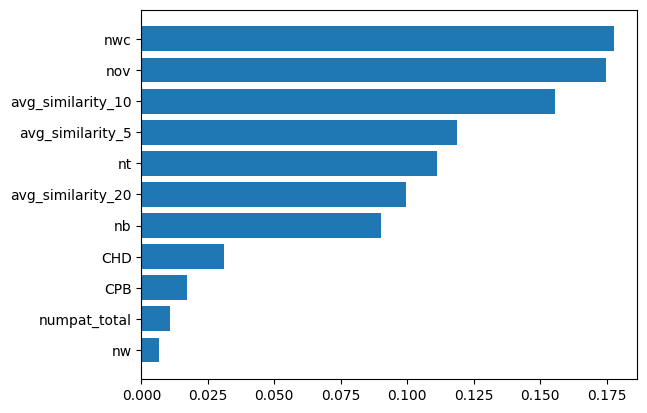

[4, 0, 11, 9, 5, 3, 6, 1, 2, 8, 7]

In [76]:
feature_names = X_train.columns

feature_imp(abs(best_model.feature_importances_), feature_names)

### Model 4
+ Effect of new patent on the following day. 
+ Missing values imputed as 0 (signaling "no innovation"). 
+ Fixed effects by company (ticker dummies).
+ Include past information for stock market variation (lags)
+ Model: RF + hyperparameter tunning

In [107]:
df_target = make_target(df, 1)
df_target.tail()

,ticker,Adj Close,date,numpat_total,avg_similarity_5,avg_similarity_10,avg_similarity_20,nw,nb,nt,nwc,nov,target_f1
8923,HSY,0.003343,2018-11-07,27.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.009070
8924,HSY,-0.009070,2018-11-08,27.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.014103
8925,HSY,0.014103,2018-11-09,27.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000829
8926,HSY,0.000829,2018-11-12,27.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.004325
8927,HSY,0.004325,2018-11-13,27.0,0.235248,0.138532,0.097133,NaN,NaN,NaN,NaN,NaN,NaN


In [108]:
# Here we generate variables for the past 3 to 120 days with a rolling mean of Adj Close
df_target["date"] = pd.to_datetime(df_target["date"])
panel_data= df_target.copy()
panel_data = panel_data.sort_values(by=['ticker', 'date'])
lcols = (panel_data.groupby(['ticker'])['Adj Close'] 
         .transform(lambda x: x.rolling(w, min_periods=1).sum()) # rolling sum of number of reports
         .rename('past' + str(w-1)) 
         for w in [4, 7, 16, 31, 61, 121])
panel_data = panel_data.join(pd.DataFrame(lcols).transpose())

In [111]:
# OHE for ticker

dummies = pd.get_dummies(panel_data['ticker'], dtype=int)
merged = pd.concat([panel_data, dummies], axis=1)

merged = merged.drop(columns=["ticker", "Adj Close", "date"])

# Filling NAs with 0 (signaling "no innovation")

merged = merged.fillna(0)

In [112]:
X = merged.drop('target_f1', axis=1)  # Features
y = merged['target_f1']  # Target variable

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a StandardScaler object
scaler = StandardScaler()

# Fit the scaler on the training features
scaler.fit(X_train)

# Apply the scaler to both the training and test features
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [113]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [50, 100, 150, 200, 300],
    'max_depth': [None, 5, 7, 10, 20],
    'min_samples_split': [2, 5, 10, 15, 20]
}

rf_model = RandomForestRegressor(random_state=42)

grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)

best_model = grid_search.best_estimator_

y_pred = best_model.predict(X_test_scaled)
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

Mean Squared Error: 0.00011962818587825299


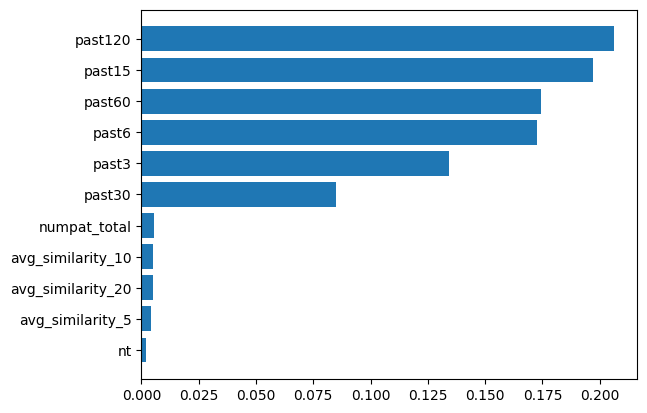

[6, 1, 3, 2, 0, 12, 9, 10, 13, 11, 14]

In [114]:
feature_names = X_train.columns

feature_imp(abs(best_model.feature_importances_), feature_names)

### Model 5

+ Effect of new patent on the following day. 
+ Missing values imputed as 0 (signaling "no innovation"). 
+ Instead of fixed effects by company (ticker dummies), one model per company.
+ Include past information for stock market variation (lags)
+ Model: RF + hyperparameter tunning



In [115]:
df_copy = panel_data.copy()

# Filling NAs with 0 (signaling "no innovation")
df_copy = df_copy.fillna(0)

# Drop unnecesary columns
df_copy = df_copy.drop(columns=["Adj Close", "date"])

In [117]:
# Get the unique company names from the DataFrame
companies = df_copy['ticker'].unique()

# Create an empty dictionary to store the trained models and MSE values
results = {}

# Define the parameter grid for grid search
param_grid = {
    'n_estimators': [50, 100, 150, 200, 300],
    'max_depth': [None, 5, 7, 10, 20],
    'min_samples_split': [2, 5, 10, 15, 20]
}

# Iterate over the companies
for company in companies:
    # Subset the data for the current company
    company_data = df_copy[df_copy['ticker'] == company]
    company_data = company_data.dropna()
    
    # Separate the features and the target variable
    X = company_data.drop(columns=["target_f1", "ticker"])
    y = company_data['target_f1']
    
     # Split the data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Standardize the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Perform grid search for hyperparameter tuning
    rf_model = RandomForestRegressor(random_state=42)
    grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
    grid_search.fit(X_train_scaled, y_train)
    
    # Get the best model from grid search
    best_model = grid_search.best_estimator_
    
    # Make predictions using the selected model
    y_pred = best_model.predict(X_test_scaled)
    
    # Calculate the mean squared error for the predictions
    mse = mean_squared_error(y_test, y_pred)
    
    # Store the best model and MSE in the dictionary
    results[company] = {
        'model': best_model,
        'mse': mse
    }



In [118]:
results

{'CHD': {'model': RandomForestRegressor(max_depth=5, n_estimators=50, random_state=42),
  'mse': 0.0001157517253895856},
 'CL': {'model': RandomForestRegressor(max_depth=5, n_estimators=200, random_state=42),
  'mse': 0.0001115193311449591},
 'CPB': {'model': RandomForestRegressor(max_depth=5, min_samples_split=20, n_estimators=300,
                        random_state=42),
  'mse': 0.0001123434095892501},
 'HSY': {'model': RandomForestRegressor(max_depth=5, min_samples_split=20, n_estimators=300,
                        random_state=42),
  'mse': 0.0001389062458668695}}

### Model 6
+ ARIMA

In [14]:
# !pip install statsmodels
from statsmodels.tsa.arima.model import ARIMA
companies = df['ticker'].unique()

In [10]:
df_timeseries = df.copy()

df_timeseries["date"] = pd.to_datetime(df_timeseries["date"])

# Set the 'date' column as the index
df_timeseries.set_index('date', inplace=True)

# Filling NAs with 0 (signaling "no innovation")
df_timeseries = df_timeseries.fillna(0)


In [16]:
import warnings
warnings.filterwarnings("ignore")

# Specify the order of the ARIMA model (p, d, q)
p = 1  # AR order
d = 1  # Differencing order
q = 1  # MA order

for company in companies:
    # Subset the data for the current company
    df_company = df_timeseries[df_timeseries['ticker'] == company].copy()
    # Resample time series because it only includes business days
    df_company = df_company.resample('B').interpolate()
    # Separate the target variable (stock values) and covariates
    y = df_company['Adj Close']
    X = df_company.drop(columns=["Adj Close", "ticker"])

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Standardize the covariates using a scaler
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Fit the ARIMA model with exogenous variables
    model = ARIMA(y_train, order=(p, d, q), exog=X_train_scaled)
    model_fit = model.fit()

    # Make predictions on the test set with exogenous variables
    y_pred = model_fit.predict(start=len(y_train), end=len(y_train) + len(y_test) - 1, exog=X_test_scaled)


    # Calculate the mean squared error (MSE) on the test set
    mse = mean_squared_error(y_test, y_pred)
    print(f"Company: {company}, Mean Squared Error: {mse}")



Company: CHD, Mean Squared Error: 0.00013153835581629329
Company: CL, Mean Squared Error: 0.0001039980958788858
Company: CPB, Mean Squared Error: 0.023335497817731646
Company: HSY, Mean Squared Error: 0.00017393445288005653
